In [ ]:
import pandas as pd
import numpy as np
import sys
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [ ]:

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def read_data(path):
    '''
    gets path of text file and returns 3 lists as below:
    sentences = [[w11,...,w1m], ..., [wn1,...,wnk]]
    slots = [[s11,...,s1m], ..., [sn1,...snk]]
    labels = [l1, ..., ln]
    '''
    sentences = []
    slots = []
    labels = []
    
    sentence = []
    slot = []

    file = open(path, 'r', encoding='utf8')

    while True:
        line = file.readline()
        if not line:
            sentences.append(sentence)
            slots.append(slot)
            return sentences, slots, labels
        else:
            token, tag = line.split()

            if token == '#':
                if not sentence:
                    labels.append(tag)
                else:
                    sentences.append(sentence)
                    sentence = []
                    slots.append(slot)
                    slot = []
                    labels.append(tag)
            else:
                sentence.append(token)
                slot.append(tag)

In [ ]:
df = pd.read_excel('dataset.xlsx')

In [ ]:
sentences, slots, labels = read_data('data.txt')

In [ ]:
df = pd.DataFrame({'text': [' '.join(s) for s in sentences],
                   'slots': [' '.join(s) for s in slots],
                   'label': labels})

In [ ]:
df.tail()

,text,slots,label
253,جوی خیابان گلستان جنوبی بالا تر از میدان معلم ...,O O B-addr_street I-addr_street O O O B-addr_s...,liaroobi
254,سلام . خسته نباشید . جوی آب کوچه ی مرادی خیابا...,O O O O O O O O O B-addr_alley O B-addr_street...,liaroobi
255,سلام . زباله های کوچه مینو پایینتر میدان ولیعص...,O O O O O B-addr_alley O O B-addr_square O O O...,liaroobi
256,سلام ما خیابان محلاتی نرسیده به اتوبان امام عل...,O O O B-addr_street O O O B-addr_highway I-add...,liaroobi
257,سلام . لطفا جوی آب رو قبل فصل بارندگی لایروبی ...,O O O O O O O O O O O O O O O O O O O O B-addr...,liaroobi


In [ ]:
df.loc[0]['text']

'سلام آقا خسته نباشید وقت به خیر ما محله دریان نو خیابون چهارم کوچه محمودی منطقه ۲ هستیم یکی از جوب های این محله گرفته و بوی بدی هم گرفته لطف کنید برای این گرفتگی این جوب اقدام کنید ممنون'

In [ ]:
df.loc[0]['slots']

'O O O O O O O O O B-addr_neighbourhood I-addr_neighbourhood O B-addr_street O B-addr_alley O B-addr_district O O O O O O O O O O O O O O O O O O O O O O O'

In [ ]:
len(df.text)

258

In [ ]:
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

In [ ]:
category_id_df

,label,category_id
0,liaroobi,0
30,nezafat,1
60,terekidegi,2


In [ ]:
category_to_id

{'liaroobi': 0, 'nezafat': 1, 'terekidegi': 2}

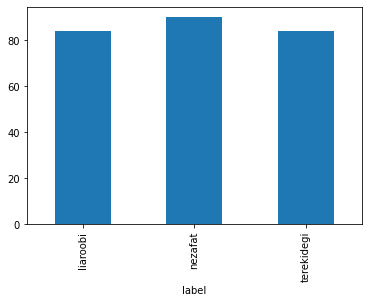

In [ ]:
fig = plt.figure()
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

# Text Representation

In [ ]:
# stopwords list in Farsi
stop_words =[  "آباد","آره","آری","آمد","آمده","آن","آنان","آنجا","آنكه","آنها","آنچه","آورد","این",
             "یه", "رو", "توی", "دیگه", "اگه", "یکی", "داره",
  "آورده","آيد","آیا","اثرِ","از","است","استفاده","اش","اكنون","البته","البتّه","ام",
  "اما","امروز","امسال","اند","انکه","او","اول","اي","ايشان","ايم","اين","اينكه","اگر",
  "با","بار","بارة","باره","باشد","باشند","باشيم","بالا","بالایِ","بايد","بدون","بر","برابرِ",
  "براساس","براي","برای","برخوردار","برخي","برداري","بروز","بسيار","بسياري","بعد","بعری","بعضي",
  "بلكه","بله","بلکه","بلی","بنابراين","بندي","به","بهترين","بود","بودن","بودند","بوده","بي","بيست",
  "بيش","بيشتر","بيشتري","بين","بی","بیرونِ","تا","تازه","تاكنون","تان","تحت","تر","ترين","تمام",
  "تمامي","تنها","تواند","توانند","توسط","تولِ","تویِ","جا","جاي","جايي","جدا","جديد","جريان","جز",
  "جلوگيري","جلویِ","حتي","حدودِ","حق","خارجِ","خدمات","خواست","خواهد","خواهند","خواهيم","خود","خويش",
  "خیاه","داد","دادن","دادند","داده","دارد","دارند","داريم","داشت","داشتن","داشتند","داشته","دانست",
  "دانند","در","درباره","دنبالِ","ده","دهد","دهند","دو","دوم","ديده","ديروز","ديگر","ديگران","ديگري",
  "دیگر","را","راه","رفت","رفته","روب","روزهاي","روي","رویِ","ريزي","زياد","زير","زيرا","زیرِ","سابق",
  "ساخته","سازي","سراسر","سریِ","سعي","سمتِ","سوم","سوي","سویِ","سپس","شان","شايد","شد","شدن","شدند",
  "شده","شش","شما","شناسي","شود","شوند","صورت","ضدِّ","ضمن","طبقِ","طريق","طور","طي","عقبِ","علّتِ",
  "عنوانِ","غير","فقط","فكر","فوق","قابل","قبل","قصدِ","كرد","كردم","كردن","كردند","كرده","كسي","كل",
  "كمتر","كند","كنم","كنند","كنيد","كنيم","كه","لطفاً","ما","مان","مانند","مانندِ","مثل","مثلِ","مختلف",
  "مدّتی","مردم","مرسی","مقابل","من","مورد","مي","ميليارد","ميليون","مگر","ناشي","نام","نبايد","نبود",
  "نخست","نخستين","نخواهد","ندارد","ندارند","نداشته","نزديك","نزدِ","نزدیکِ","نشان","نشده","نظير","نكرده",
  "نمايد","نمي","نه","نوعي","نيز","نيست","ها","هاي","هايي","هر","هرگز","هزار","هست","هستند","هستيم","هفت",
  "هم","همان","همه","همواره","همين","همچنان","همچنين","همچون","همین","هنوز","هنگام","هنگامِ","هنگامی","هيچ",
  "هیچ","و","وسطِ","وقتي","وقتیکه","ولی","وي","وگو","يا","يابد","يك","يكديگر","يكي","ّه","پاعینِ","پس","پنج",
  "پيش","پیش","پیشِ","چرا","چطور","چند","چندین","چنين","چه","چهار","چون","چيزي","چگونه","چیز","چیزی","چیست",
  "کجا","کجاست","کدام","کس","کسی","کنارِ","که","کَی","کی","گذاري","گذاشته","گردد","گرفت","گرفته","گروهي","گفت",
  "گفته","گويد","گويند","گيرد","گيري","یا","یک", '؟', '!', '٪', '.', '،', '؛', ':', ';', ',']

In [ ]:
df['cleaned_text'] = ''

In [ ]:
for index in range(len(df.text)):
  result = ""
  for word in word_tokenize(df.text[index]):
    if word not in stop_words:
      result = result + " " + word
  df.cleaned_text[index] = result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',  ngram_range=(1, 2))
features = tfidf.fit_transform(df.cleaned_text).toarray()
labels = df.category_id
features.shape

(258, 424)

# Terms that are the most correlated

In [ ]:
N = 2
for label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'liaroobi':
  . Most correlated unigrams:
. جوب
. جوی
  . Most correlated bigrams:
. بوی بدی
. جوی آب
# 'nezafat':
  . Most correlated unigrams:
. آب
. نظافت
  . Most correlated bigrams:
. جمع آوری
. نظافت کوچه
# 'terekidegi':
  . Most correlated unigrams:
. ترکیده
. لوله
  . Most correlated bigrams:
. ترکیده آب
. آب هدر


# Model Selection

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [ ]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

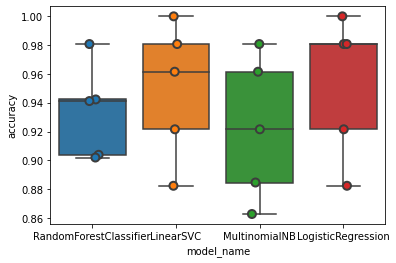

In [ ]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.949246
LogisticRegression        0.953092
MultinomialNB             0.922247
RandomForestClassifier    0.934012
Name: accuracy, dtype: float64

# Model Evaluation
Continue with the  model: LogisticRegression        

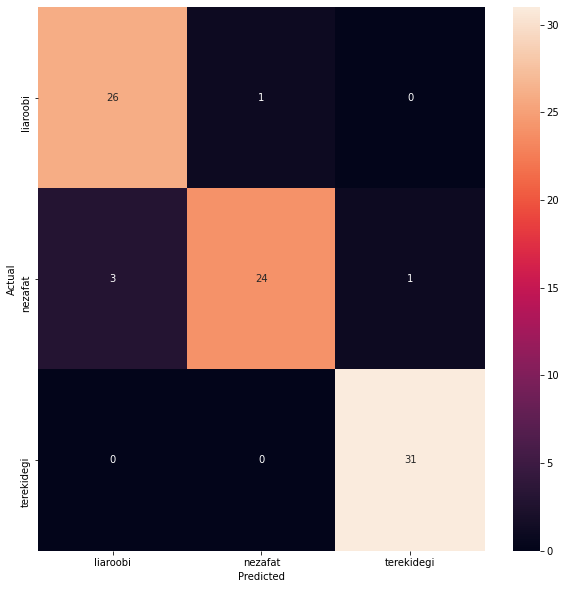

In [ ]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Misclassifications

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 1:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      print(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['text']])
      print('')

'nezafat' predicted as 'liaroobi' : 3 examples.
                                                  text
231  سلام . ببخشید مغازه دار های محله فاطمی خیابان ...
92   سلام وقتتون بخیر چند وقته که سطل سر کوچه ما را...
247  لطفا اطلاع بدید که کوچه ی شکوفه ، خیابان احمدی...

'liaroobi' predicted as 'nezafat' : 1 examples.
                                                text
8  سلام خسته نباشید خیبان حجاب خیابان فاطمی که می...

'nezafat' predicted as 'terekidegi' : 1 examples.
                                                  text
124  سلام روز بخیر یک لوله مربوط به آبیاری هست داخل...



# Terms that are the most correlated

In [ ]:
model.fit(features, labels)
N = 2
for Label, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(label))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'terekidegi':
  . Top unigrams:
       . جوی
       . جوب
  . Top bigrams:
       . جوی آب
       . داخل جوی
# 'terekidegi':
  . Top unigrams:
       . نظافت
       . کوچه
  . Top bigrams:
       . نظافت کوچه
       . کوچه تمیز
# 'terekidegi':
  . Top unigrams:
       . لوله
       . ترکیده
  . Top bigrams:
       . آب هدر
       . ترکیده آب


# Classification report

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['label'].unique()))

              precision    recall  f1-score   support

    liaroobi       0.90      0.96      0.93        27
     nezafat       0.96      0.86      0.91        28
  terekidegi       0.97      1.00      0.98        31

    accuracy                           0.94        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.94      0.94      0.94        86



# Prediction with text

In [ ]:
test_text = ["سلام وقت به به خیر این محله ما چندین روز هست کسی برای جارو کردن نیامده لطفا یه نظر رو بفرستید یه جارو بزنه"]

In [ ]:
pred = model.predict(tfidf.transform(test_text).toarray())
pred

array([1])

In [ ]:
id_to_category[pred[0]]

'nezafat'

### Get top n probabilities

In [ ]:
n = 3         # top 3 probabilities

probas = model.predict_proba(tfidf.transform(test_text).toarray())
best_n = np.flip(np.argsort(probas, axis=1)[:,-n:])
best_n

array([[1, 0, 2]])

# Saving models and features to disk

In [ ]:
import pickle

In [ ]:
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = 'tfidf.sav'
pickle.dump(tfidf, open(filename, 'wb'))

In [ ]:
filename = 'id_to_category.sav'
pickle.dump(id_to_category, open(filename, 'wb'))